# change to 3 class classification

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import uproot
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools
from collections import Counter
from sklearn.metrics import classification_report
import seaborn as sns

In [2]:
def plot_roc_curve(fpr, tpr, auc, i):
    ax.plot(fpr, tpr, label=f'{classes[i]} ROC score: {auc:.3f}')
    ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate')
    plt.legend()

In [3]:
path = '/vols/cms/dw515/Offline/output/SM/masters_signal_vs_background_combined/'
write_path = '/home/hep/shc3117/MSci-Project-HiggsTauTau/shared/signal_background/'

In [4]:
vbfh_tree = uproot.open(path+'VBFH.root')['ntuple']
ztt_tree = uproot.open(path+'ZTT.root')['ntuple']
fakes_tree = uproot.open(path+'fakes.root')['ntuple']
ggh_tree = uproot.open(path+'ggH.root')['ntuple']

In [5]:
variables = ['pt_1','pt_2', 'm_vis','svfit_mass','mjj','jpt_1','pt_tt','met','n_jets','pt_vis','iso_1','iso_2', 'wt']
selectors = ['rand', 'wt_cp_sm', 'deepTauVsJets_medium_1', 'deepTauVsJets_medium_2', 'trg_doubletau', 'os']

In [6]:
vbfh = vbfh_tree.pandas.df(variables+selectors)
ztt = ztt_tree.pandas.df(variables+selectors)
fakes = fakes_tree.pandas.df(variables+selectors)
ggh = ggh_tree.pandas.df(variables+selectors)

In [7]:
vbfh = vbfh[vbfh['deepTauVsJets_medium_1'] & vbfh['deepTauVsJets_medium_2'] & vbfh['trg_doubletau'] & vbfh['os']]
ztt = ztt[ztt['deepTauVsJets_medium_1'] & ztt['deepTauVsJets_medium_2'] & ztt['trg_doubletau'] & ztt['os']]
fakes = fakes[fakes['deepTauVsJets_medium_1'] & fakes['deepTauVsJets_medium_2'] & fakes['trg_doubletau'] & (fakes['os']==0)]
ggh = ggh[ggh['deepTauVsJets_medium_1'] & ggh['deepTauVsJets_medium_2'] & ggh['trg_doubletau'] & ggh['os']]

In [8]:
scaling = {
    'ggh': 0.0022034,
    'vbfh': 0.0001486,
    'fakes': 1.35,
    'ztt': 3.6292,
}

In [9]:
vbfh.loc[:, 'w'] = vbfh.wt*vbfh.wt_cp_sm *scaling['vbfh']
ztt.loc[:, 'w'] = ztt.wt *scaling['ztt']
fakes.loc[:, 'w'] = fakes.wt *scaling['fakes']
ggh.loc[:, 'w'] = ggh.wt*ggh.wt_cp_sm *scaling['ggh']

In [10]:
higgs = pd.concat([vbfh, ztt]).reset_index(drop=True)

In [11]:
higgs.loc[:, 'y'] = np.zeros(higgs.shape[0])
ztt.loc[:, 'y'] = np.ones(ztt.shape[0])
fakes.loc[:, 'y'] = np.full((fakes.shape[0],),2.)

In [12]:
df = pd.concat([higgs, ztt, fakes]).reset_index(drop=True)

In [13]:
df.y

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
994761    2.0
994762    2.0
994763    2.0
994764    2.0
994765    2.0
Name: y, Length: 994766, dtype: float64

In [14]:
df = df[df.wt > 0]

In [15]:
print(sorted(Counter(df.y).items()))

[(0.0, 859943), (1.0, 33487), (2.0, 100831)]


In [16]:
higgs.w.sum(), ztt.w.sum(), fakes.w.sum()

(36986.96240881552, 36877.137177970326, 136121.85)

# base case

In [17]:
df_1 = df.drop(selectors+['iso_1', 'iso_2'], axis=1)

In [18]:
# xgb_params = {
#     "objective": "multi:softmax",
#     "max_depth": 6,
#     "num_classes": 4,
# }
xgb_params = {
    "objective": "multi:softprob",
    "max_depth": 3,
    "learning_rate": 0.05,
    "silent": 1,
    "n_estimators": 1000,
    "subsample": 0.9,
    "seed": 123451,
}

xgb_clf = xgboost.XGBClassifier(**xgb_params)
# xgb_clf = xgboost.XGBClassifier()


In [19]:
df_1.drop(['y', 'wt'], axis=1).columns

Index(['pt_1', 'pt_2', 'm_vis', 'svfit_mass', 'mjj', 'jpt_1', 'pt_tt', 'met',
       'n_jets', 'pt_vis', 'w'],
      dtype='object')

In [20]:
X = df_1.drop(['y', 'wt'], axis=1).to_numpy()
y = df_1.y.astype(int)
w = df_1.w
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, y, w, test_size=0.2, random_state=1, stratify=df_1.y)

In [21]:
eval_set = [(X_train, y_train), (X_test, y_test)]
xgb_clf.fit(X_train, y_train, sample_weight=w_train, verbose=2, early_stopping_rounds=50, eval_set=eval_set, eval_metric = "mlogloss", sample_weight_eval_set=[w_train, w_test])
# xgb_clf.fit(X_train, y_train, sample_weight=w_train, verbose=2, eval_metric="mlogloss")

/home/hep/shc3117/anaconda3/envs/msci/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:59:12] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-mlogloss:1.04440	validation_1-mlogloss:1.04458
[2]	validation_0-mlogloss:0.94949	validation_1-mlogloss:0.94998
[4]	validation_0-mlogloss:0.86898	validation_1-mlogloss:0.86987
[6]	validation_0-mlogloss:0.80006	validation_1-mlogloss:0.80119
[8]	validation_0-mlogloss:0.74040	validation_1-mlogloss:0.74177
[10]	validation_0-mlogloss:0.68839	validation_1-mlogloss:0.68996
[12]	validation_0-mlogloss:0.64281	validation_1-mlogloss:0.64456
[14]	validation_0-mlogloss:0.60261	validation_1-mlogloss:0.60460
[16]	validation_0-mlogloss:0.56712	validation_1-mlogloss:0.56925
[18]	validation_0-mlogloss:0.53563	validation_1-mlogloss:0.53789
[20]	validation_0-mlogloss:0.

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=16, num_parallel_tree=1,
              objective='multi:softprob', random_state=123451, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, seed=123451, silent=1,
              subsample=0.9, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [30]:
y_pred = xgb_clf.predict_proba(X_test)
onehot=label_binarize(y_test,classes=[0,1,2])
fpr=dict()
tpr=dict()
thresh = dict()
roc_auc=dict()
for i in range(3):
    fpr[i], tpr[i], thresh[i] = roc_curve(onehot[:,i], y_pred[:,i],sample_weight=w_test)
    roc_auc[i] = auc(fpr[i], tpr[i])

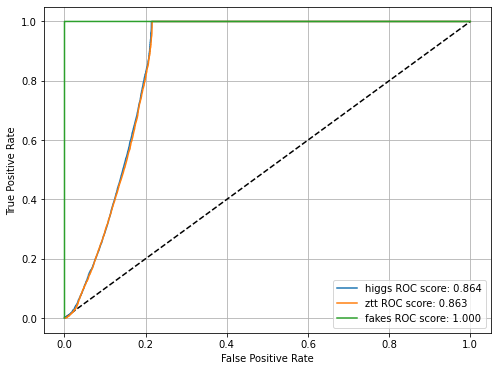

In [31]:
classes = ['higgs', 'ztt', 'fakes']
fig, ax = plt.subplots(figsize=(8,6))
lims = [np.min([ax.get_xlim(), ax.get_ylim()]), np.max([ax.get_xlim(), ax.get_ylim()])]
# ax.set_xlim(lims)
# ax.set_ylim(lims)
ax.plot(lims, lims, 'k--')
ax.grid()
for i in range(len(fpr)):
    plot_roc_curve(fpr[i],tpr[i],roc_auc[i], i)
# plot_roc_curve(fpr[1],tpr[1],roc_auc[1], 1)
# plot_roc_curve(fpr[2],tpr[2],roc_auc[2], 2)
# plot_roc_curve(fpr[3],tpr[3],roc_auc[3], 3)
# plt.savefig('/signal_background/eda/roc_curves.png')

/home/hep/shc3117/anaconda3/envs/msci/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


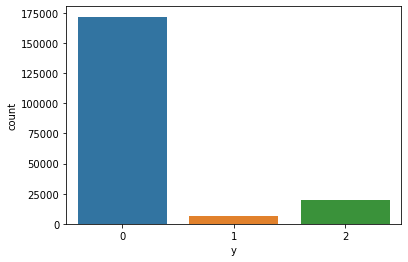

In [25]:
sns.countplot(y_test)
plt.show()

In [26]:
cr = classification_report(y_test, xgb_clf.predict(X_test), output_dict=True, target_names=classes, sample_weight=w_test)
pd.DataFrame(cr).transpose()

,precision,recall,f1-score,support
higgs,0.395694,0.326598,0.357841,7525.962338
ztt,0.420006,0.494356,0.454158,7423.840770
fakes,1.000000,1.000000,1.000000,27224.100000
accuracy,0.790823,0.790823,0.790823,0.790823
macro avg,0.605233,0.606985,0.604000,42173.903108
weighted avg,0.790065,0.790823,0.789322,42173.903108


In [104]:
df_1.loc[:, 'y_pred']  = xgb_clf.predict(X)

In [114]:
df_1.drop(['y', 'wt'], axis=1).columns

Index(['pt_1', 'pt_2', 'm_vis', 'svfit_mass', 'mjj', 'jpt_1', 'pt_tt', 'met',
       'n_jets', 'pt_vis', 'w', 'y_pred'],
      dtype='object')

In [148]:
df_test = pd.DataFrame(X_test, columns=df_1.drop(['y', 'wt'], axis=1).columns).reset_index(drop=True)

In [147]:
(y_test==2).sum()

20166

In [149]:
df_test['y'] = y_test.to_numpy()
df_test['w'] = w_test.to_numpy()

In [150]:
df_test['y_pred'] = xgb_clf.predict(X_test)

In [151]:
df_test

,pt_1,pt_2,m_vis,svfit_mass,mjj,jpt_1,pt_tt,met,n_jets,pt_vis,w,y,y_pred
0,92.282034,53.676795,92.767455,115.830387,777.012285,111.839663,138.882213,29.351910,2.0,114.518214,0.000053,0,0
1,41.703584,40.880400,85.186898,101.254921,507.899335,98.537312,23.169485,24.799908,2.0,2.083170,0.000024,0,0
2,129.497680,81.550319,92.653429,124.638680,2601.815534,256.477620,283.144277,88.702454,4.0,195.046717,0.000063,0,0
3,42.768679,40.478256,83.106576,139.588425,970.733272,75.777211,81.928694,77.720337,1.0,6.513472,0.000157,0,0
4,52.635335,52.384945,101.074869,108.849537,169.383822,41.276124,30.110152,9.723588,3.0,39.826468,0.000056,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
198848,86.956464,54.072191,84.667066,98.186611,491.818811,143.600868,144.432830,30.410059,2.0,118.070496,0.000057,0,0
198849,54.342384,50.044678,106.130171,142.722984,-9999.000000,38.905858,51.391301,56.381241,1.0,5.797828,0.000154,0,0
198850,332.635573,71.107560,85.773144,124.196709,809.351633,787.601410,691.283480,294.794250,2.0,396.512134,0.000135,0,0
198851,66.861926,42.956125,105.681926,125.633175,364.414807,94.597766,77.411184,12.334446,3.0,67.925730,0.000063,0,0
